                                        #### Project 4
# Regression Models on College Data

_Author: Alex Chicote (NYC)_

---
<img src="./pexels-photo-356086.jpeg" style="float: center; margin: 20px; height: 300px">

                                            What are the most important features that define
                                            college tuition in the US?
        

## Plan of Action

### Steps:



   - [1. Importing all the modules and dataframes from Notebook(AChicote-Project-3-NB-1-EDA).](#importing)
   - [2. Finding the baseline (score to beat).](#baseline)
   - [3. Some plotting to understand better our dataset.](#plotting)
   - [4. Exposition of strategy.](#strategy)
   - [5. Selecting features and running models.](#models)
   - [6. Evaluating the model and some more plotting.](#analysis)
   - [7. Next steps.](#steps)
   

<a id='importing'></a>

In [17]:
import pandas as pd
import requests
import json
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import rfe, SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
%matplotlib inline

## Recover dataframe

In [18]:
data = pd.read_csv('df_final.csv')

data.shape

(6604, 185)

In [6]:
data.head()

,id,alias,branches,carnegie_basic,carnegie_size_setting,carnegie_undergrad,degrees_awarded.highest,degrees_awarded.predominant,faculty_salary,ft_faculty_rate,...,state_fips_55,state_fips_56,state_fips_60,state_fips_64,state_fips_66,state_fips_68,state_fips_69,state_fips_70,state_fips_72,state_fips_78
0,412003,0,1,10.0,1.0,3.0,2,1,1551.000000,0.564079,...,0,0,0,0,0,0,0,0,0,0
1,443058,1,1,24.0,7.0,11.0,3,3,667.000000,0.564079,...,0,0,0,0,0,0,0,0,0,0
2,443225,0,2,-3.0,-2.0,-2.0,1,1,6235.119579,0.564079,...,0,0,0,0,0,0,0,0,0,0
3,443252,0,1,-3.0,-2.0,-2.0,1,1,6235.119579,0.564079,...,0,0,0,0,0,0,0,0,0,0
4,443261,1,1,-3.0,-2.0,-2.0,1,1,6235.119579,0.564079,...,0,0,0,0,0,0,0,0,0,0


<a id='baseline'></a>
# BASELINE =  7586.41

In [19]:
##Baseline
data['mean'] = data['cost'].mean()

y_test = data['cost'].values
prediction_mean = data['mean'].values
baseline = np.sqrt(mean_squared_error(y_test, prediction_mean))
print(baseline)

7586.41376138


<a id='plotting'></a>
# Plotting

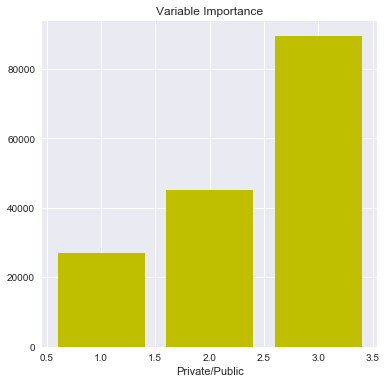

In [8]:
## ownership seems to me like a good feature
plt.subplots(figsize=(6,6))
plt.bar(data['ownership'], data['cost'], color='y')
plt.xlabel('Private/Public')
plt.title('Variable Importance')
plt.show()

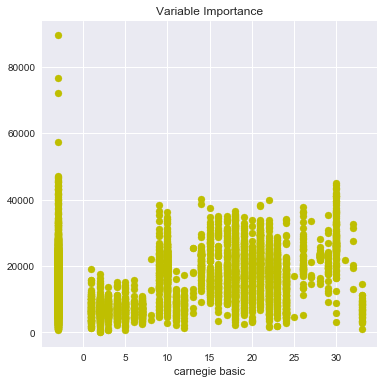

In [96]:
plt.subplots(figsize=(6,6))
#plt.scatter(data['tuition_revenue_per_fte'], y,color='b')
plt.scatter(data['carnegie_basic'], data['cost'], color='y')
plt.xlabel('carnegie basic')
plt.title('Variable Importance')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1207b0ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128a071d0>]], dtype=object)

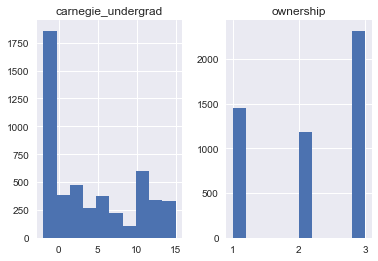

In [97]:
X_train.hist(column=['ownership', 'carnegie_undergrad'])


<a id='strategy'></a>

## This dataset has many similarities with Ames Dataset:

    1. There the target was the sale price of real estate, while now is the tuition/cost of colleges.
    2. There are a big amount of features as there are in Ames IO -including dummies.
    3. This is why I will use the same metric: RMSE (Root Mean Squared Error).
    4. I will focus in the model that worked better: Gradient Boosting Regressor.
    5. Use of all viable features to start.
    6. Repeat the process while filtering (eliminating features until reaching the score.
    7. Evaluating the final model and plotting it.


<a id='models'></a>
## Selecting features with correlation

In [20]:
correlation = data.corr()['cost'].apply(lambda x: abs(x)).sort_values(ascending=False)[1:6]
correlation

correlation_list = (correlation.index)[1:]
correlation_list

Index(['carnegie_undergrad', 'open_admissions_policy',
       'degrees_awarded.highest', 'carnegie_basic'],
      dtype='object')

In [21]:
valid_columns = [c for c in data.columns if c not in ['cost', 'id', 'title_iv.approval_date', 'mean']]
y = data['cost']
X = data[valid_columns]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

## Selecting features with regularization while running first model

In [27]:
lr = LassoCV()
lr_params = {}
lr_model = GridSearchCV(lr, param_grid=lr_params)
lr_model.fit(Xs_train, y_train)
print('best score', lr_model.best_score_)
print('best params', lr_model.best_params_)
print('test score', lr_model.score(Xs_test, y_test))
predictions = lr_model.predict(Xs_test)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print(RMSE)
first_try = RMSE

best score 0.572772635819
best params {}
test score 0.5830739354
5051.97253738


In [25]:
coeff_lasso = list(zip(valid_columns, lr_model.best_estimator_.coef_))
coeff_lasso.sort(key=lambda x: abs(x[1]))
coeff_lasso.reverse()
coeff_lasso[0:5]

feature_name_lasso, coefficients_lasso = [list(c) for c in zip(*coeff_lasso)]
feature_name_lasso[0:5], coefficients_lasso[0:5]

absoluts_coeff = [abs(k) for k in coefficients_lasso[0:5]]

feature_name_lasso[0:5]

['ownership', 'carnegie_undergrad', 'NACCAS', 'state_fips_72', 'AARTS']

## Analyzing first model results

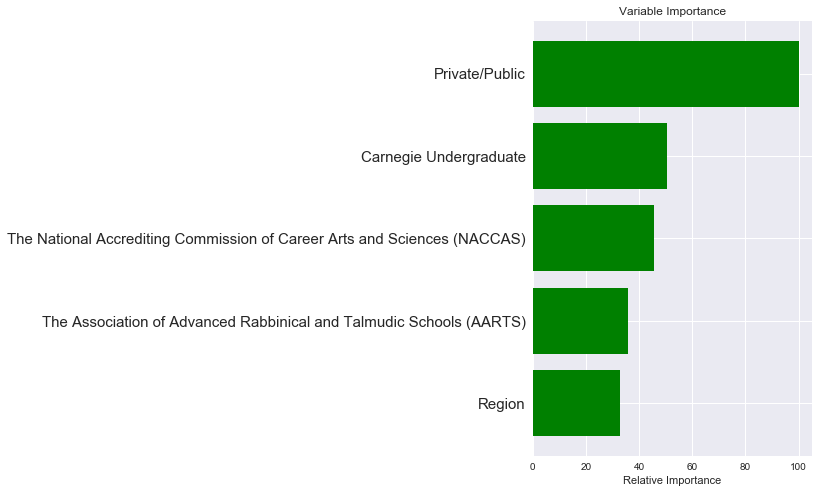

In [26]:
feature_importance = absoluts_coeff[0:5]
feature_importance = 100.0 * (feature_importance / max(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

llista =['Private/Public', 'Carnegie Undergraduate',\
         'The National Accrediting Commission of Career Arts and Sciences (NACCAS)',\
         'The Association of Advanced Rabbinical and Talmudic Schools (AARTS)',\
        "Region"]
plt.subplots(figsize=(5,8))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='g')
plt.yticks(pos, llista[::-1], fontsize =15)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<a id='analysis'></a>
## Best model obtained. Its analysis

In [28]:
gbc = GradientBoostingRegressor()
gbc_params = {'n_estimators': [175, 200, 225, 250, 275], 'max_features': ['auto', 'log2', None], 'max_depth': range(1,4)}
gbc_model = GridSearchCV(gbc, param_grid=gbc_params)
gbc_model.fit(Xs_train, y_train)
print('best score', gbc_model.best_score_)
print('best params', gbc_model.best_params_)
print('test score', gbc_model.score(Xs_test, y_test))
predictions = gbc_model.predict(Xs_test)
#prediction = gbc_model.predict(XTs)
#test['SalePrice'] = prediction
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print('gbc', RMSE)
second_try = RMSE

best score 0.624354138779
best params {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 275}
test score 0.640942342527
gbc 4688.28014174


In [111]:
fea_imp = list(zip(valid_columns, gbc_model.best_estimator_.feature_importances_))
fea_imp.sort(key=lambda x: abs(x[1]))
fea_imp.reverse()
fea_imp[0:5]

[('instructional_expenditure_per_fte', 0.10720690529744924),
 ('seniority', 0.086310366838724423),
 ('faculty_salary', 0.071936039962064713),
 ('ownership', 0.066380822302487943),
 ('branches', 0.054714420426868048)]

In [112]:
feature_name, feature_importance = [list(c) for c in zip(*fea_imp)]
feature_name[0:5], feature_importance[0:5]

(['instructional_expenditure_per_fte',
  'seniority',
  'faculty_salary',
  'ownership',
  'branches'],
 [0.10720690529744924,
  0.086310366838724423,
  0.071936039962064713,
  0.066380822302487943,
  0.054714420426868048])

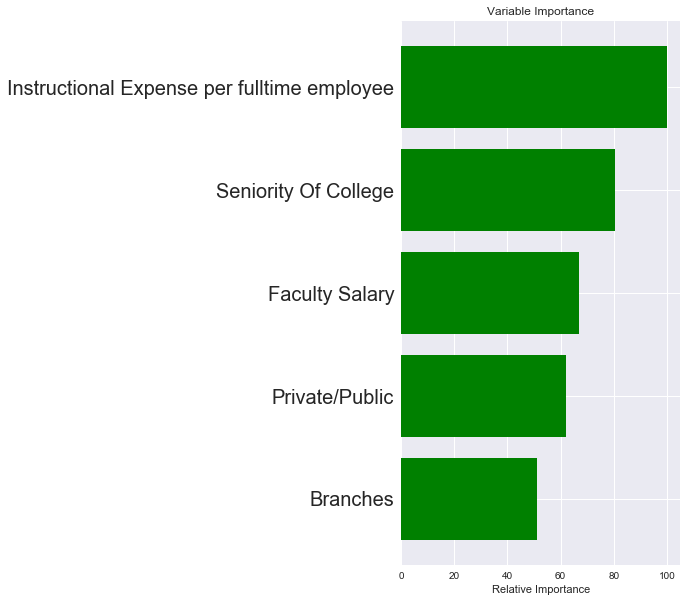

In [114]:
feature_importance = feature_importance[:5]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / max(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
llista_gbc =['Instructional Expense per fulltime employee', 'Seniority Of College','Faculty Salary',\
             'Private/Public','Branches']

plt.subplots(figsize=(5,10))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='g')
plt.yticks(pos, llista_gbc[::-1], fontsize =20)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [137]:
gbc =GradientBoostingRegressor(max_depth=3, max_features='log2', n_estimators=225)
gbc.fit(Xs_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=225, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

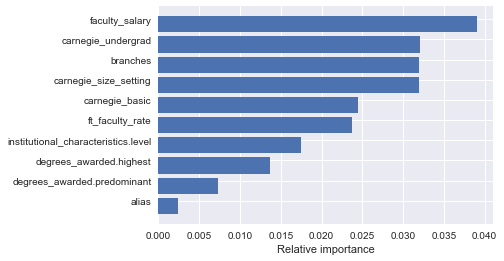

In [138]:
# sort importances
indices = np.argsort(gbc.feature_importances_[0:10])
# plot as bar chart
plt.barh(np.arange(len(feature_name[0:10])), gbc.feature_importances_[indices])
plt.yticks(np.arange(len(feature_name[0:10])) + 0.25, np.array(valid_columns)[indices])
_ = plt.xlabel('Relative importance')

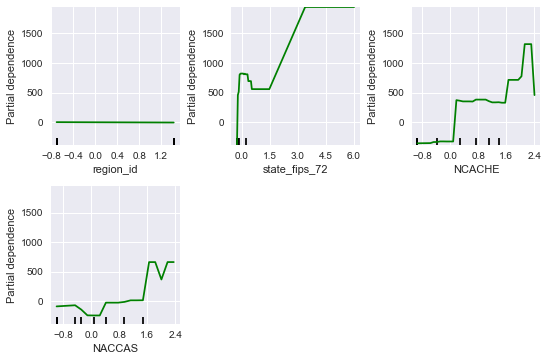

In [141]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['region_id', 'state_fips_72', 'NCACHE', 'NACCAS',
            ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(gbc, Xs_train, feature_name[0:4], 
                                   feature_names= feature_name[0:4], figsize=(8, 8))

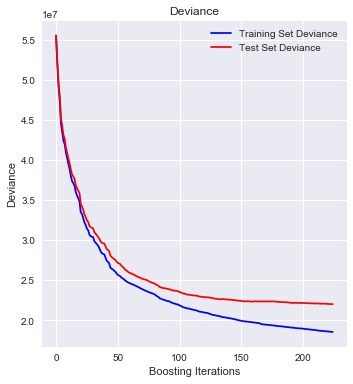

In [142]:
test_score = np.zeros(225, dtype=np.float64)

for i, y_pred in enumerate(gbc.staged_predict(Xs_test)):
    test_score[i] = gbc.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(225), gbc.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(225), test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

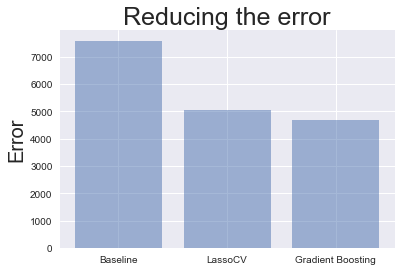

In [29]:
objects = ('Baseline', 'LassoCV', 'Gradient Boosting')
y_pos = np.arange(len(objects))
performance = [baseline,first_try,second_try]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Error', fontsize=20)
plt.title('Reducing the error', fontsize=25)
 
plt.show()

<a id='steps'></a>
### Steps:



   - [1. Use SelectKBest and Rfe for feature selection.](#othermodels)
   - [2. Run other models just in case. I actually did in part and only SVR showed some similar results).](#baseline)
   - [3. I did some of it but never got to better prediction. Reducing features to avoid overfitting](#plotting)
   - [4. My RMSE scored has been fluctuating a lot everytime I run it which suggest overfitting.](#demames)

In [164]:
lr = LinearRegression()
rfe = RFE(lr, verbose=1, n_features_to_select=100)

rfe.fit(Xs_train, y_train)

Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
F

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=100, step=1, verbose=1)

In [120]:
##AdaBoost
ada = AdaBoostRegressor()
ada_params = {'n_estimators': [25, 50, 75],
             'loss': ['linear', 'square', 'exponential']}
ada_model = GridSearchCV(ada, param_grid=ada_params)
ada_model.fit(Xs_train, y_train)
print('best score', ada_model.best_score_)
print('best params', ada_model.best_params_)
print('test score', ada_model.score(Xs_test, y_test))
predictions = ada_model.predict(Xs_test)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print(RMSE)

##LinearRegression
lr = LinearRegression()
lr_params = {}
lr_model = GridSearchCV(lr, param_grid=lr_params)
lr_model.fit(Xs_train, y_train)
print('best score', lr_model.best_score_)
print('best params', lr_model.best_params_)
print('test score', lr_model.score(Xs_test, y_test))
predictions = lr_model.predict(Xs_test)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print(RMSE)
##Ridge


svm = SVR()

svm_params = {'C': range(20,40),
             'kernel': ['linear', 'poly', 'rbf']}
svm_model = GridSearchCV(svm, param_grid=svm_params)
svm_model.fit(Xs_train, y_train)
print('best score', svm_model.best_score_)
print('best params', svm_model.best_params_)
print('test score', svm_model.score(Xs_test, y_test))
predictions = svm_model.predict(Xs_test)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print(RMSE)

best score 0.463437658164
best params {'loss': 'exponential', 'n_estimators': 25}
test score 0.452752159978
5597.19920782
best score -1.98158583139e+27
best params {}
test score -2.49701243369e+22
1.19560876006e+15
best score 0.574069967252
best params {'C': 39, 'kernel': 'linear'}
test score 0.552033763474
5064.08955232


## Going back to gbc

## I will select some features

In [123]:
correlation100 = data.corr()['cost'].apply(lambda x: abs(x)).sort_values(ascending=False)[1:101]
correlation_list100 = (correlation100.index)[1:]
correlation_list100

Index(['carnegie_undergrad', 'open_admissions_policy',
       'degrees_awarded.highest', 'carnegie_basic', 'locale',
       'institutional_characteristics.level', 'carnegie_basic_2.0',
       'degrees_awarded.predominant', 'main_campus', 'carnegie_basic_30.0',
       'carnegie_size_setting', 'branches', 'minority_serving.hispanic',
       'region_id_9', 'state_fips_72', 'instructional_expenditure_per_fte',
       'NACCAS', 'religious_affiliation', 'locale_11.0', 'carnegie_basic_10.0',
       'carnegie_basic_7.0', 'carnegie_basic_3.0', 'carnegie_basic_21.0',
       'ACICS', 'locale_41.0', 'WASCJC', 'carnegie_basic_4.0',
       'carnegie_basic_1.0', 'region_id', 'carnegie_basic_5.0', 'operating',
       'locale_33.0', 'seniority', 'WASCSR', 'region_id_1', 'ACCSC', 'SACSCC',
       'AAAA', 'NEACHE', 'id', 'state_fips_25', 'state_fips', 'COE',
       'locale_32.0', 'locale_21.0', 'AARTS', 'OKSBVT', 'carnegie_basic_14.0',
       'state_fips_40', 'carnegie_basic_28.0', 'region_id_2',
       

In [146]:
Xs_train.shape, y_train.shape

((4953, 182), (4953,))

## Recursive Feature Elimination

In [169]:
rfe_features100 = []
for col, keep in zip(X_train.columns, rfe.support_):
    if keep == True:
        rfe_features100.append(col)
print(len(rfe_features100))

100


## SelectKbest

In [179]:
selectkbest = SelectKBest(f_regression, k=100)
selectkbest.fit(Xs_train, y_train)
selectk_100 = []
for col, keep in zip(X_train.columns, selectkbest.get_support()):
    if keep == True:
        selectk_100.append(col)
print(len(selectk_100))

100


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [180]:
llista_seleccio = [selectk_100, rfe_features100, correlation_list100, feature_name_lasso[0:100]]

for item in llista_seleccio:
    y = data['cost']
    X = data[item]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

    

    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    gbc = GradientBoostingRegressor()
    gbc_params = {'n_estimators': [175, 200, 225, 250, 275], 'max_features': ['auto', 'log2', None], 'max_depth': range(1,4)}
    gbc_model = GridSearchCV(gbc, param_grid=gbc_params)
    gbc_model.fit(Xs_train, y_train)
    print('best score', gbc_model.best_score_)
    print('best params', gbc_model.best_params_)
    print('test score', gbc_model.score(Xs_test, y_test))
    predictions = gbc_model.predict(Xs_test)
    #prediction = gbc_model.predict(XTs)
    #test['SalePrice'] = prediction
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('gbc', RMSE)

In [183]:
correlation50 = data.corr()['cost'].apply(lambda x: abs(x)).sort_values(ascending=False)[1:51]
correlation_list50 = (correlation50.index)[1:]
selectkbest = SelectKBest(f_regression, k=50)
selectkbest.fit(Xs_train, y_train)
selectk_50 = []
for col, keep in zip(X_train.columns, selectkbest.get_support()):
    if keep == True:
        selectk_50.append(col)
print(len(selectk_50))

50


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [184]:
lr = LinearRegression()
rfe = RFE(lr, verbose=1, n_features_to_select=50)

rfe.fit(Xs_train, y_train)
rfe_features50 = []
for col, keep in zip(X_train.columns, rfe.support_):
    if keep == True:
        rfe_features50.append(col)
print(len(rfe_features50))

Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 f

In [185]:
llista_seleccio50 = [selectk_50, rfe_features50, correlation_list50, feature_name_lasso[0:50]]

for item in llista_seleccio50:
    y = data['cost']
    X = data[item]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

    

    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    gbc = GradientBoostingRegressor()
    gbc_params = {'n_estimators': [175, 200, 225, 250, 275], 'max_features': ['auto', 'log2', None], 'max_depth': range(1,4)}
    gbc_model = GridSearchCV(gbc, param_grid=gbc_params)
    gbc_model.fit(Xs_train, y_train)
    print('best score', gbc_model.best_score_)
    print('best params', gbc_model.best_params_)
    print('test score', gbc_model.score(Xs_test, y_test))
    predictions = gbc_model.predict(Xs_test)
    #prediction = gbc_model.predict(XTs)
    #test['SalePrice'] = prediction
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('gbc', RMSE)

best score 0.494091164499
best params {'max_depth': 3, 'max_features': None, 'n_estimators': 275}
test score 0.48764827808
gbc 5440.43805882
best score 0.489414719453
best params {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 275}
test score 0.496339931319
gbc 5259.67153227
best score 0.582225988923
best params {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 275}
test score 0.579915984142
gbc 4884.97887136
best score 0.482015183331
best params {'max_depth': 3, 'max_features': None, 'n_estimators': 275}
test score 0.520157919119
gbc 4980.83370429
